# Table Detection using Faster RCNN
This project aims to perform **Documents Tables Detection** on UNLV dataset using Deep Learning. 

The proposed methodology for carrying out Table Detection in Documents consists of Faster Region based Convolutional Neural Network (Faster RCNN) for detection as its basic element. Faster RCNN is further divided into several layers where each layer contribute to detection. Faster RCNN is composed of following layers:

- Feature Extraction Layer to extract features from images
- Region Proposal Network (RPN) Layer that gives proposals for different set of regions in an image
- Region of Interest Layer that filters out from the proposed regions based on threshold

Following are the libraries that we will import.

In [1]:
# Import Libraries
# !pip install tensorflow-gpu==2.0.0alpha0
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras import losses
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import math
import random
from keras.utils.generic_utils import Progbar
# from keras.backend import image_dim_ordering
from keras.backend import image_data_format
import copy

2022-12-07 17:34:17.377226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yash/Desktop/Courses/CS1430/cv_env/lib/python3.9/site-packages/cv2/../../lib64:
2022-12-07 17:34:17.377243: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Download Data
First, we need the data. For this project, we will download and extract the **UNLV dataset**. The dataset can be downloaded from the link [here](https://drive.google.com/file/d/1ETq5hhoIgCzzom6yivkokhQ8DoOm6nDs/view?usp=sharing). 

In [9]:
# # Download data from local repository
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content
# !mkdir data_fasterrcnn
# !cp -r "/content/gdrive/My Drive/Google Colab Workspace/Table Detection using Faster RCNN/data.zip" "/content/data_fasterrcnn/"

# # Unzip data
# !unzip /content/data_fasterrcnn/data -d /content/data_fasterrcnn/

## Data Preprocessing

### Load Ground Truth CSV Files
After downloading the dataset, we can see that there is an `images` folder and two csv files i.e. `train.csv` and `test.csv`. The next step is to load both the csv files into pandas dataframe for easy indexing.

The code below loads the csv files into pandas dataframe.

In [12]:
!ls data/

images	train.csv  val.csv


In [2]:
# Load CSV Files into DataFrames
train_file = pd.read_csv('data/train.csv',names=['image_names','xmin','ymin','xmax','ymax','class'])
test_file = pd.read_csv('data/val.csv',names=['image_names','xmin','ymin','xmax','ymax','class'])

# Display DataFrames
print("\nTraining Ground Truth")
display(train_file.head())
print("\nTesting Ground Truth")
display(test_file.head())


Training Ground Truth


,image_names,xmin,ymin,xmax,ymax,class
0,0101_003.png,770,946,2070,2973,table
1,0110_099.png,270,1653,2280,2580,table
2,0113_013.png,303,343,2273,2953,table
3,0140_007.png,664,1782,1814,2076,table
4,0146_281.png,704,432,1744,1552,table



Testing Ground Truth


,image_names,xmin,ymin,xmax,ymax,class
0,9533_039.png,60,396,1113,2420,table
1,9533_039.png,1143,1126,2240,2230,table
2,9534_001.png,196,378,2146,956,table
3,9534_001.png,184,1028,2160,1636,table
4,9534_028.png,642,1388,1944,1981,table


### Resize Images and Bbox Coordinates
As the original images are much larger in size such that the smallest width and the smallest height is 2544px.  This may cause memory overflow during training. Also the images are all not of same size, so we will resize the images to 256 x 256 pixels and resize the bounding box coordinates according to it.

Following code resize the images and bounding box coordinates.

In [3]:
def data_loading_and_resizing(image_file):
  image_list = image_file['image_names'].unique()
  images = []
  labels = []
  for image_name in image_list:
    image = cv2.imread('data/images/'+image_name)

    x_scale = 256 / image.shape[1]
    y_scale = 256 / image.shape[0]
    
    # Resize Images to 256px x 256px
    image = cv2.resize(image, (256,256)) 
    
    # Resize the bbox coordinates
    image_file.loc[image_file['image_names'] == image_name,'xmin'] = np.round(image_file.loc[image_file['image_names'] == image_name,'xmin'] * x_scale)
    image_file.loc[image_file['image_names'] == image_name,'ymin'] = np.round(image_file.loc[image_file['image_names'] == image_name,'ymin'] * y_scale)
    image_file.loc[image_file['image_names'] == image_name,'xmax'] = np.round(image_file.loc[image_file['image_names'] == image_name,'xmax'] * x_scale)
    image_file.loc[image_file['image_names'] == image_name,'ymax'] = np.round(image_file.loc[image_file['image_names'] == image_name,'ymax'] * y_scale)
  
    bboxes = image_file.loc[image_file['image_names'] == image_name,'xmin':'ymax'].values.astype(np.int32)
    labels.append(bboxes)

    images.append(image)
  
  return images, labels, image_file

In [4]:
# Resize and Load Data
train_images, train_labels, train_file = data_loading_and_resizing(train_file)
test_images, test_labels, test_file = data_loading_and_resizing(test_file)

# Display DataFrames
print("\nResized Training Ground Truth")
display(train_file.head())
print("\nResized Testing Ground Truth")
display(test_file.head())


Resized Training Ground Truth


,image_names,xmin,ymin,xmax,ymax,class
0,0101_003.png,77,73,208,231,table
1,0110_099.png,27,128,229,200,table
2,0113_013.png,30,27,229,229,table
3,0140_007.png,66,138,181,161,table
4,0146_281.png,71,34,175,120,table



Resized Testing Ground Truth


,image_names,xmin,ymin,xmax,ymax,class
0,9533_039.png,6,31,112,188,table
1,9533_039.png,115,87,225,173,table
2,9534_001.png,20,29,215,74,table
3,9534_001.png,18,80,217,127,table
4,9534_028.png,64,108,195,154,table


In [5]:
train_labels[0].shape

(1, 4)

### Data Visualization
Before generating the ground truth anchors, the most important task is to visualize the training and testing dataset.

In [6]:
def visualize(index_list, images, labels):
  rows = 2
  columns = 3
  fig=plt.figure(figsize=(16, 12))
  for i, index in enumerate(index_list):
    fig.add_subplot(rows, columns, i+1, xticks=[], yticks=[])
    image = images[index]
    for label in labels[index]:
      cv2.rectangle(image,(label[0], label[1]),(label[2],label[3]),(255, 0, 0))
    plt.imshow(image)
  plt.show()

Train Image Dataset


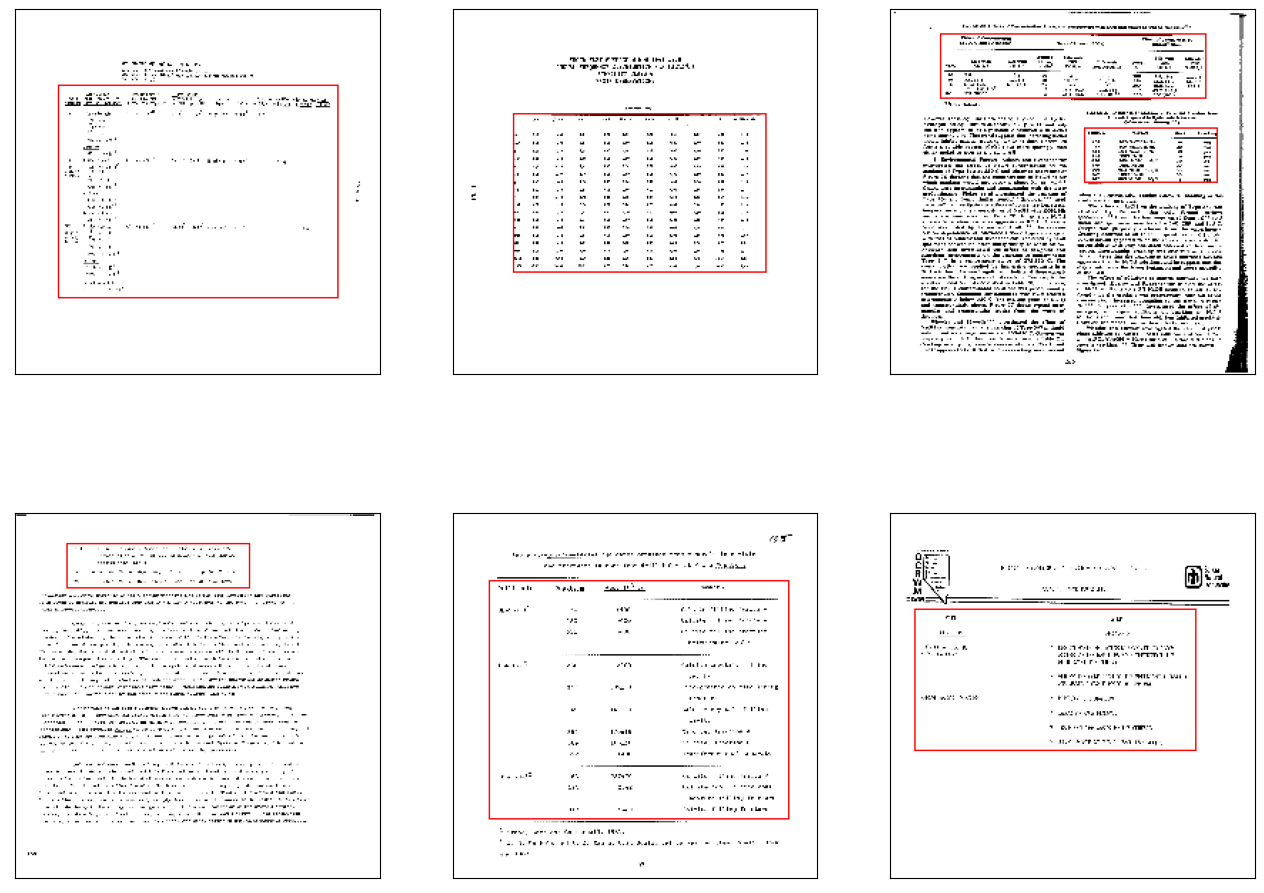

In [7]:
print('Train Image Dataset')
visualize([12,53,110,135,200,259], np.copy(train_images), train_labels)

Test Image Dataset


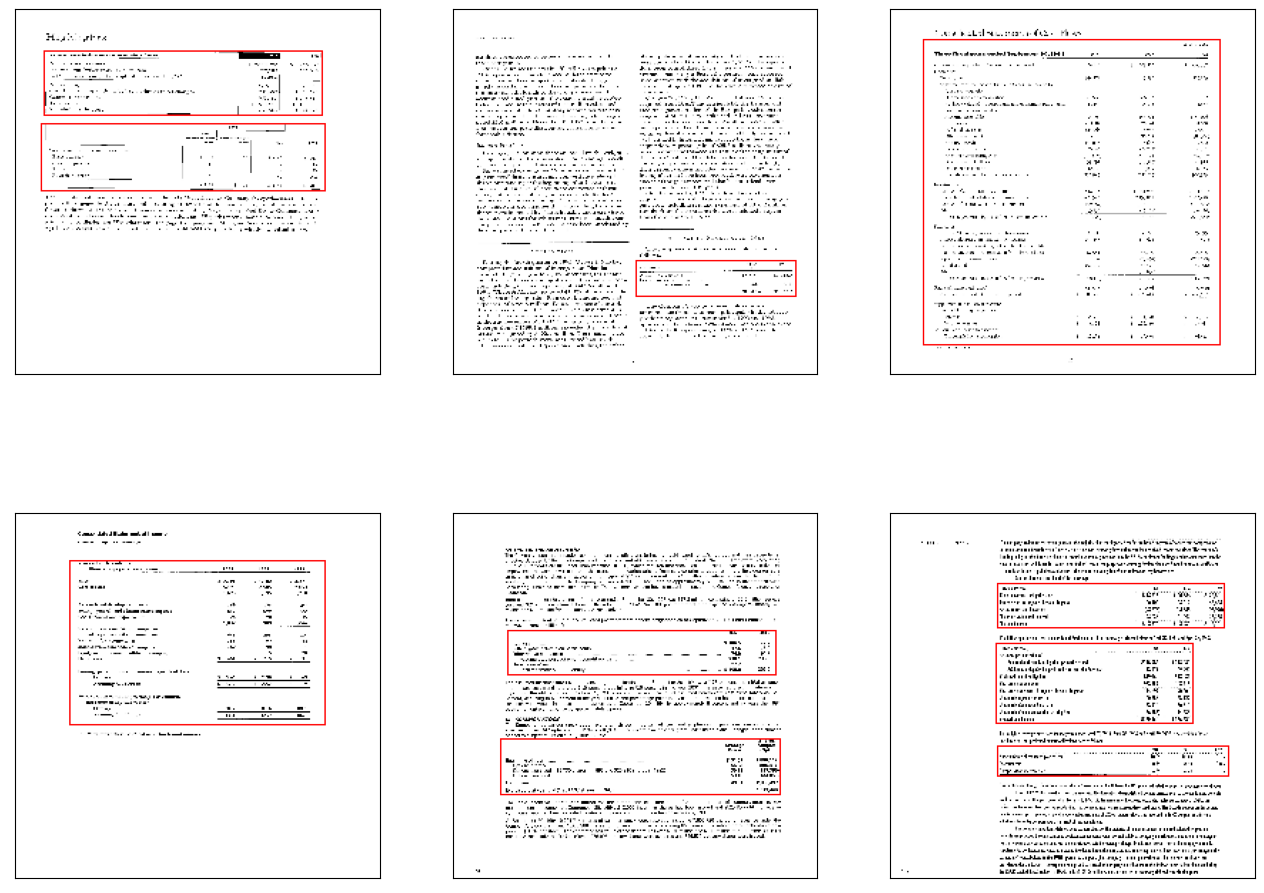

In [8]:
print('Test Image Dataset')
visualize([1,5,10,15,20,25], np.copy(test_images), test_labels)

### Generate Ground Truth Anchors
From above visualization we can see that the number of tables in a document image vary and therefore we cannot pass the bbox coordinates as ground truth in tensorflow model. In order to solve the variable length problem we will generate fixed number of anchors that serve as reference bounding boxes.

Following code generates fixed number of ground truth anchors for images.

In [9]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

In [10]:
def calc_rpn(image_data, labels, width, height, resized_width, resized_height):
  
  downscale = float(16)
  anchor_sizes = [64, 128, 256]
  anchor_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
  num_anchors = 9
  
  output_width = resized_width // 16
  output_height = resized_height // 16
  
  n_anchratios = len(anchor_ratios)
  
  num_bboxes = len(labels)
  
  y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
  y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
  y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))
  
  num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
  best_anchor_for_bbox = -1 * np.ones((num_bboxes, 4)).astype(int)
  best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
  best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
  best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)
  
  gta = np.zeros((num_bboxes, 4))
  for bbox_num, label in enumerate(labels):
		# get the GT box coordinates, and resize to account for image resizing
    gta[bbox_num, 0] = label[0]
    gta[bbox_num, 1] = label[1]
    gta[bbox_num, 2] = label[2]
    gta[bbox_num, 3] = label[3]
  
  for anchor_size_idx in range(len(anchor_sizes)):
    for anchor_ratio_idx in range(n_anchratios):
      anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
      anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]
      
      for ix in range(output_width):					
				# x-coordinates of the current anchor box
        x1_anc = downscale * (ix + 0.5) - anchor_x / 2
        x2_anc = downscale * (ix + 0.5) + anchor_x / 2	
				
				# ignore boxes that go across image boundaries
        if x1_anc < 0 or x2_anc > resized_width:
          continue
        
        for jy in range(output_height):

					# y-coordinates of the current anchor box
          y1_anc = downscale * (jy + 0.5) - anchor_y / 2
          y2_anc = downscale * (jy + 0.5) + anchor_y / 2

					# ignore boxes that go across image boundaries
          if y1_anc < 0 or y2_anc > resized_height:
            continue

					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
          bbox_type = 'neg'

					# this is the best IOU for the (x,y) coord and the current anchor
					# note that this is different from the best IOU for a GT bbox
          best_iou_for_loc = 0.0
          
          for bbox_num in range(num_bboxes):
						
						# get IOU of the current GT box and the current anchor box
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						# calculate the regression targets if they will be needed
            if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > 0.7:
              cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
              cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
              cxa = (x1_anc + x2_anc)/2.0
              cya = (y1_anc + y2_anc)/2.0

							# x,y are the center point of ground-truth bbox
							# xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
							# w,h are the width and height of ground-truth bbox
							# wa,ha are the width and height of anchor bboxe
							# tx = (x - xa) / wa
							# ty = (y - ya) / ha
							# tw = log(w / wa)
							# th = log(h / ha)
              tx = (cx - cxa) / (x2_anc - x1_anc)
              ty = (cy - cya) / (y2_anc - y1_anc)
              tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
              th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
            
            #if image_data['bboxes'][bbox_num]['class'] != 'bg':

            # all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
            if curr_iou > best_iou_for_bbox[bbox_num]:
              best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
              best_iou_for_bbox[bbox_num] = curr_iou
              best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
              best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

            # we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
            if curr_iou > 0.7:
              bbox_type = 'pos'
              num_anchors_for_bbox[bbox_num] += 1
              # we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
              if curr_iou > best_iou_for_loc:
                best_iou_for_loc = curr_iou
                best_regr = (tx, ty, tw, th)

            # if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
            if 0.3 < curr_iou < 0.7:
              # gray zone between neg and pos
              if bbox_type != 'pos':
                bbox_type = 'neutral'

					# turn on or off outputs depending on IOUs
          if bbox_type == 'neg':
            y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
            y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
          elif bbox_type == 'neutral':
            y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
            y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
          elif bbox_type == 'pos':
            y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
            y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
            start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
            y_rpn_regr[jy, ix, start:start+4] = best_regr

	# we ensure that every bbox has at least one positive RPN region
  for idx in range(num_anchors_for_bbox.shape[0]):
    if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero ...
      if best_anchor_for_bbox[idx, 0] == -1:
        continue
      y_is_box_valid[best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3]] = 1
      y_rpn_overlap[best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3]] = 1
      start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
      y_rpn_regr[best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]
  
  y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
  y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)
  
  y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
  y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)
  
  y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
  y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)
  
  pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
  neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))
  
  num_pos = len(pos_locs[0])

	# one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
	# regions. We also limit it to 256 regions.
  num_regions = 256
  
  if len(pos_locs[0]) > num_regions/2:
    val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
    y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
    num_pos = num_regions/2
  
  if len(neg_locs[0]) + num_pos > num_regions:
    val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
    y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0
  
  y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
  y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)
  
  return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

In [11]:
def get_anchor_gt(images, labels):
  resized_width = 256
  resized_height = 256
  while True:
    for index in range(len(images)):
      image_data = images[index]
      label_data = labels[index]
      try:

        try:
          y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(image_data, label_data, 256, 256, resized_width, resized_height)
        except:
          continue

        # Zero-center by mean pixel, and preprocess image

        image_data = image_data[:,:, (2, 1, 0)]  # BGR -> RGB
        image_data = image_data.astype(np.float32)
        image_data[:, :, 0] -= 103.939
        image_data[:, :, 1] -= 116.779
        image_data[:, :, 2] -= 123.68
        image_data /= 1.0

        image_data = np.transpose(image_data, (2, 0, 1))
        image_data = np.expand_dims(image_data, axis=0)

        y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= 1.0

        image_data = np.transpose(image_data, (0, 2, 3, 1))
        y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
        y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

        yield np.copy(image_data), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], label_data, index

      except Exception as e:
        print(e)
        continue

## Define Model Layers
The model that is implemented in this project consists of following layers:

- Feature Extraction Layer to extract features from images
- Region Proposal Network (RPN) Layer that gives proposals for different set of regions in an image
- RPN to Region of Interest (RoI) Layer that convert the rpn proposals into different regions.
- Region of Interest Layer that filters out from the proposed regions based on threshold.


### Feature Extraction Layer
The first step in our model is to use any CNN based model to extract features from the images. For this project we will use **VGG16** as the base model, pretrained on **ImageNet**, for extracting features from the images. We will use the output of second last layer before max pooling and send it to the Region Proposal Network Layer.

In [12]:
IMG_SHAPE = (256, 256, 3)
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
bottleneck_input  = base_model.get_layer(index=0).input
bottleneck_output = base_model.get_layer(index=-2).output
base_model  = tf.keras.models.Model(inputs=bottleneck_input, outputs=bottleneck_output)

2022-12-07 17:34:38.954077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yash/Desktop/Courses/CS1430/cv_env/lib/python3.9/site-packages/cv2/../../lib64:
2022-12-07 17:34:38.954104: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-07 17:34:38.954124: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yash-ThinkPad-L390): /proc/driver/nvidia/version does not exist
2022-12-07 17:34:38.954352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

### Region Proposel Network Layer
Using the features extracted by pretrained VGG16, RPN is used to find upto a predefined number of regions (bounding boxes) which contains objects. RPN takes the number of anchors as an input and output a set of good proposals. RPN consists of a convolution layer, classification layer and a regression layer. For each anchor, RPN outputs an objectness score, that we get from the classification layer, and a set of bounding box coordinates that we get from the regression layer.

In [14]:
def RPN_Layer(base_layer, num_anchors):
  '''
    base_layer: vgg16
    num_anchors: 9
  '''
  x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layer)

  x_class = tf.keras.layers.Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
  x_regr = tf.keras.layers.Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

  return [x_class, x_regr, base_layer]

### RPN to Region Of Interest 
The next layer is RPN to RoI layer that converts anchors into regions of interest, remove duplicate proposals (proposals that overlap each other by IoU greater than 0.7) using the non max suppression technique and pick bounding boxes upto a max number i.e. 300 (in our case).

In [15]:
def apply_regr_np(X, T):
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X

In [16]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list

    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]


    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

In [17]:
# RPN to ROI
def rpn_to_roi(rpn_layer, regr_layer, dim_ordering, use_regr=True, max_boxes=10,overlap_thresh=0.9):
	
	regr_layer = regr_layer / 4.0

	anchor_sizes = [64, 128, 256]   # (3 in here)
	anchor_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]  # (3 in here)


	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/ 16
			anchor_y = (anchor_size * anchor_ratio[1])/ 16
			
			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4]
			regr = np.transpose(regr, (2, 0, 1)) 

			
			# For every point in x, there are all the y points and vice versa
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  
	all_probs = np.transpose(rpn_layer,(0, 3, 1, 2)).reshape((-1))                  

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

### Filter Regions Of Interest
Now for the final layer of the model, using the regions or bounding boxes picked in the last layer, we can now filter those regions that have an overlap greater than 0.65 with the ground truth boxes. However, for calculating the accuracy metric (intersection of union) we involve only those regions that have an overlap greater than 0.3 with the ground truth boxes.

In [18]:
def filter_roi(labels, Y_pred, thresh= 0.3):
  filter_labels = []
  iou_acc = []
  for label in labels:
    for predicted in Y_pred:
      label_iou = iou(label, predicted)
      if label_iou > thresh:
        iou_acc.append(label_iou)
        filter_labels.append(predicted)
  
  if iou_acc == []:
    mean = 0
  else:
    mean = np.mean(np.asarray(iou_acc))
  
  return filter_labels, mean 

## Define Classification and Regression Loss


In [19]:
epsilon = 1e-4

In [20]:
# RPN Loss Regression
def rpn_loss_regr(num_anchors):

    def rpn_loss_regr_fixed_num(y_true, y_pred):

        # x is the difference between true value and predicted vaue
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return 1.0 * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num

In [21]:
# RPN Loss Classification
def rpn_loss_cls(num_anchors):
 
    def rpn_loss_cls_fixed_num(y_true, y_pred):

            return 1.0 * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])

    return rpn_loss_cls_fixed_num


## Model Initialization

In [22]:
input_image = tf.keras.layers.Input(shape=(None,None,3))
# VGG16 gives feature map
vgg16 = base_model(input_image)
# RPN Layer x_regr gives mean distance between anchors
rpn = RPN_Layer(vgg16,9)


model_rpn = tf.keras.models.Model(input_image, rpn[:2])
model_rpn.compile(optimizer='adam', loss=[rpn_loss_cls(9), rpn_loss_regr(9)], metrics = ["acc"])
model_rpn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 model (Functional)             (None, 16, 16, 512)  14714688    ['input_2[0][0]']                
                                                                                                  
 rpn_conv1 (Conv2D)             (None, 16, 16, 512)  2359808     ['model[0][0]']                  
                                                                                                  
 rpn_out_class (Conv2D)         (None, 16, 16, 9)    4617        ['rpn_conv1[0][0]']        

## Training

In [31]:
num_epochs = 5
epoch_num=0
losses = np.zeros((338, 3))
loss_cls = []
loss_regr = []
accuracy = []

## NOTE from Yash: 
The below cell contains the original code from the repository. I have commented it out and broken in down into a couple of cells below while testing. 

In [ ]:
# for epoch_num in range(num_epochs):
#   progbar = Progbar(338)
#   print('Epoch {}/{}'.format(epoch_num + 1, num_epochs))
  
#   data_gen_train = get_anchor_gt(train_images, train_labels)
#   iter_num = 0
#   while True:
#     try:
      
#       # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
#       X, Y, labels, index = next(data_gen_train)

#       # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
#       loss_rpn = model_rpn.train_on_batch(X, Y)

#       # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
#       P_rpn = model_rpn.predict_on_batch(X)
#       R_pred = rpn_to_roi(P_rpn[0], P_rpn[1],image_dim_ordering(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
#       R_pred = R_pred * 16
#       pred_labels, acc = filter_roi(labels, R_pred)

#       losses[iter_num, 0] = loss_rpn[1]
#       losses[iter_num, 1] = loss_rpn[2]
#       losses[iter_num, 2] = acc

#       iter_num += 1

#       progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),('acc', np.mean(losses[:iter_num, 2]))])
      
#       if iter_num == 338:
#         loss_rpn_cls = np.mean(losses[:, 0])
#         loss_rpn_regr = np.mean(losses[:, 1])
#         mean_iou = np.mean(losses[:, 2])
#         loss_cls.append(loss_rpn_cls)
#         loss_regr.append(loss_rpn_regr)
#         accuracy.append(mean_iou)
        
#         print('Loss RPN Classifier: ', loss_rpn_cls)
#         print('Loss RPN Regressor: ', loss_rpn_regr)
#         print('Mean IOU: ', mean_iou)

#         break

#     except Exception as e:
#       print('Exception: {}'.format(e))
#       continue
      
# print("Training complete!")

In [32]:
print('Epoch {}/{}'.format(epoch_num + 1, num_epochs))

data_gen_train = get_anchor_gt(train_images, train_labels)
iter_num = 0

progbar = Progbar(338)

Epoch 1/5


In [33]:
while True:

    # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
    X, Y, labels, index = next(data_gen_train)
    # print("here 1")

    # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
    loss_rpn = model_rpn.train_on_batch(X, Y)
    # print("here 2")

    # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
    P_rpn = model_rpn.predict_on_batch(X)
    R_pred = rpn_to_roi(P_rpn[0], P_rpn[1],'tf', use_regr=True, overlap_thresh=0.7, max_boxes=300)
    R_pred = R_pred * 16
    pred_labels, acc = filter_roi(labels, R_pred)
    # print("here 3")

    losses[iter_num, 0] = loss_rpn[1]
    losses[iter_num, 1] = loss_rpn[2]
    losses[iter_num, 2] = acc
    # print("here 4")

    iter_num += 1
    # print("iter_num", iter_num)

    progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),('acc', np.mean(losses[:iter_num, 2]))])

    if iter_num == 338:
        loss_rpn_cls = np.mean(losses[:, 0])
        loss_rpn_regr = np.mean(losses[:, 1])
        mean_iou = np.mean(losses[:, 2])
        loss_cls.append(loss_rpn_cls)
        loss_regr.append(loss_rpn_regr)
        accuracy.append(mean_iou)

        print('Loss RPN Classifier: ', loss_rpn_cls)
        print('Loss RPN Regressor: ', loss_rpn_regr)
        print('Mean IOU: ', mean_iou)

        break


110/338 [========>.....................] - ETA: 3:50 - rpn_cls: 1.1164 - rpn_regr: 10.6927 - acc: 0.3923

/tmp/ipykernel_121347/3359906402.py:18: RuntimeWarning: overflow encountered in exp
  w1 = np.exp(tw.astype(np.float64)) * w
/tmp/ipykernel_121347/3136329908.py:50: RuntimeWarning: invalid value encountered in add
  A[2, :, :, curr_layer] += A[0, :, :, curr_layer]


112/338 [========>.....................] - ETA: 3:48 - rpn_cls: 1.1157 - rpn_regr: 10.5874 - acc: 0.3924

/tmp/ipykernel_121347/3359906402.py:18: RuntimeWarning: overflow encountered in multiply
  w1 = np.exp(tw.astype(np.float64)) * w


338/338 [==============================] - 400s 1s/step - rpn_cls: 1.0895 - rpn_regr: 11.2855 - acc: 0.3926
Loss RPN Classifier:  1.1844318635579636
Loss RPN Regressor:  7.978685808029114
Mean IOU:  0.39215110661017133


## Training and Testing Accuracy

In [54]:
def calculate_accuracy(images, labels, losses):
  progbar = Progbar(338)
  print('Epoch 1/1')
  
  data_gen = get_anchor_gt(images, labels)
  iter_num = 0
  
  while True:
    try:
      
      # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
      X, Y, labels, index = next(data_gen)

      # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
      loss_rpn = model_rpn.train_on_batch(X, Y)

      # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
      P_rpn = model_rpn.predict_on_batch(X)
      R_pred = rpn_to_roi(P_rpn[0], P_rpn[1], 'tf', use_regr=True, overlap_thresh=0.7, max_boxes=300)
      R_pred = R_pred * 16
      pred_labels, acc = filter_roi(labels, R_pred)

      losses[iter_num, 0] = loss_rpn[1]
      losses[iter_num, 1] = loss_rpn[2]
      losses[iter_num, 2] = acc

      iter_num += 1

      progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),('acc', np.mean(losses[:iter_num, 2]))])
      
      if iter_num == 338:
        return np.mean(losses[:, 1]), np.mean(losses[:, 2])
        break

    except Exception as e:
      print(e)
      continue

In [56]:
train_losses = np.zeros((338, 3))
test_losses = np.zeros((338, 3))

_, train_acc = calculate_accuracy(train_images, train_labels, train_losses)
print("Training Accuracy: ", train_acc * 100)

_, test_acc = calculate_accuracy(test_images, test_labels, test_losses)
print("Testing Accuracy: ", test_acc * 100)

Epoch 1/1
338/338 [==============================] - 450s 1s/step - rpn_cls: 0.9070 - rpn_regr: 0.0359 - acc: 0.4154
Training Accuracy:  39.14981163013269
Epoch 1/1
338/338 [==============================] - 444s 1s/step - rpn_cls: 1.8081 - rpn_regr: 0.2197 - acc: 0.3982
Testing Accuracy:  41.04052254540981


## Loss Curves

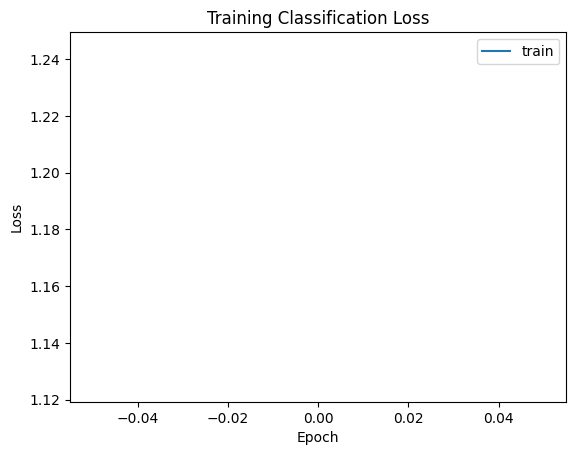

In [57]:
# Classification Loss
plt.plot(loss_cls)   
plt.title('Training Classification Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train']) 
plt.show()

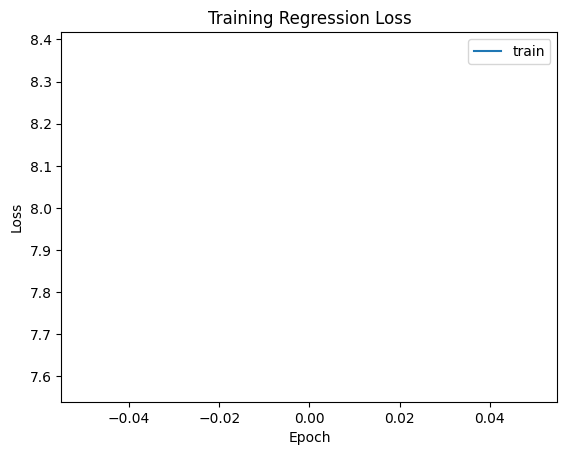

In [58]:
# Regression Loss
plt.plot(loss_regr)   
plt.title('Training Regression Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train']) 
plt.show()

## Accuracy Curves

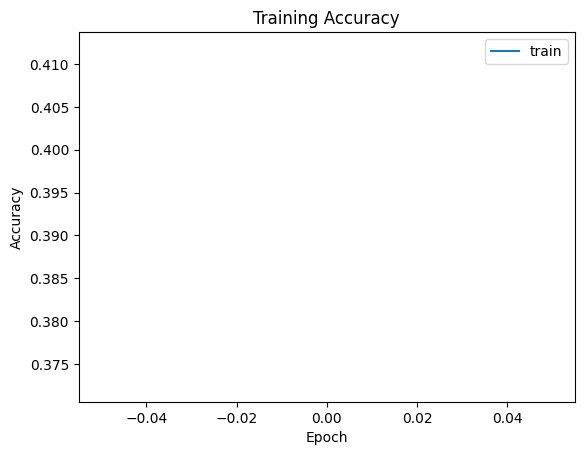

In [59]:
# Regression Loss
plt.plot(accuracy)   
plt.title('Training Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train']) 
plt.show()

## Testing

In [63]:
def predict_labels(data_gen):
  X, Y, labels, index = next(data_gen)
  P_rpn = model_rpn.predict_on_batch(X)
  R_pred = rpn_to_roi(P_rpn[0], P_rpn[1], 'tf', use_regr=True, overlap_thresh=0.4, max_boxes=300)
  R_pred = R_pred * 16
  pred_labels, acc = filter_roi(labels, R_pred, 0.6)
  
  return pred_labels, index

def inference(data_gen, images):
  rows = 2
  columns = 3
  fig=plt.figure(figsize=(16, 12))
  for i in range(6):
    fig.add_subplot(rows, columns, i+1, xticks=[], yticks=[])
    labels, index = predict_labels(data_gen)
    image = images[index]
    for label in labels:
      cv2.rectangle(image,(label[0], label[1]),(label[2],label[3]),(255, 0, 0))
    plt.imshow(image)
  plt.show()

In [64]:
data_gen_train = get_anchor_gt(train_images, train_labels)
data_gen_test = get_anchor_gt(test_images, test_labels)

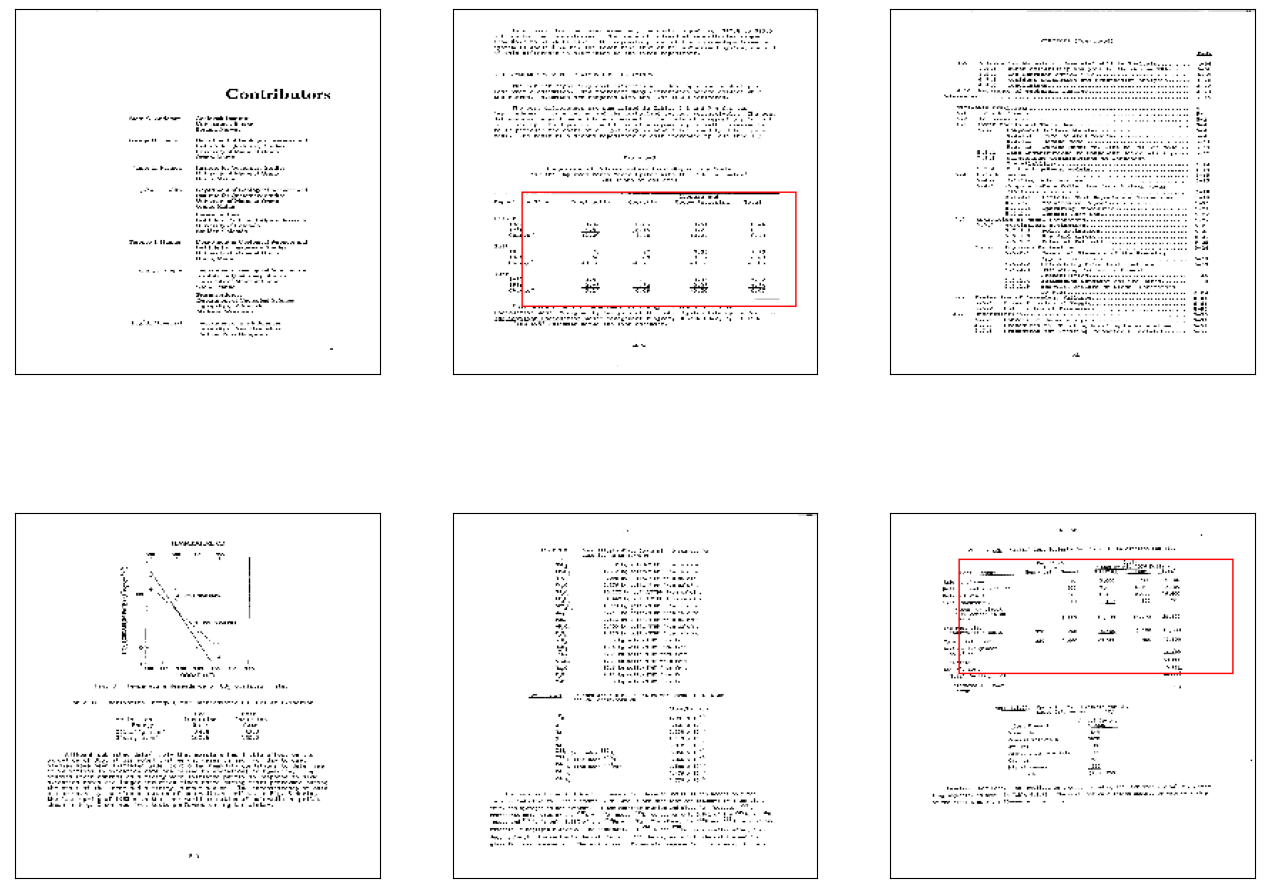

In [65]:
inference(data_gen_train, np.copy(train_images))

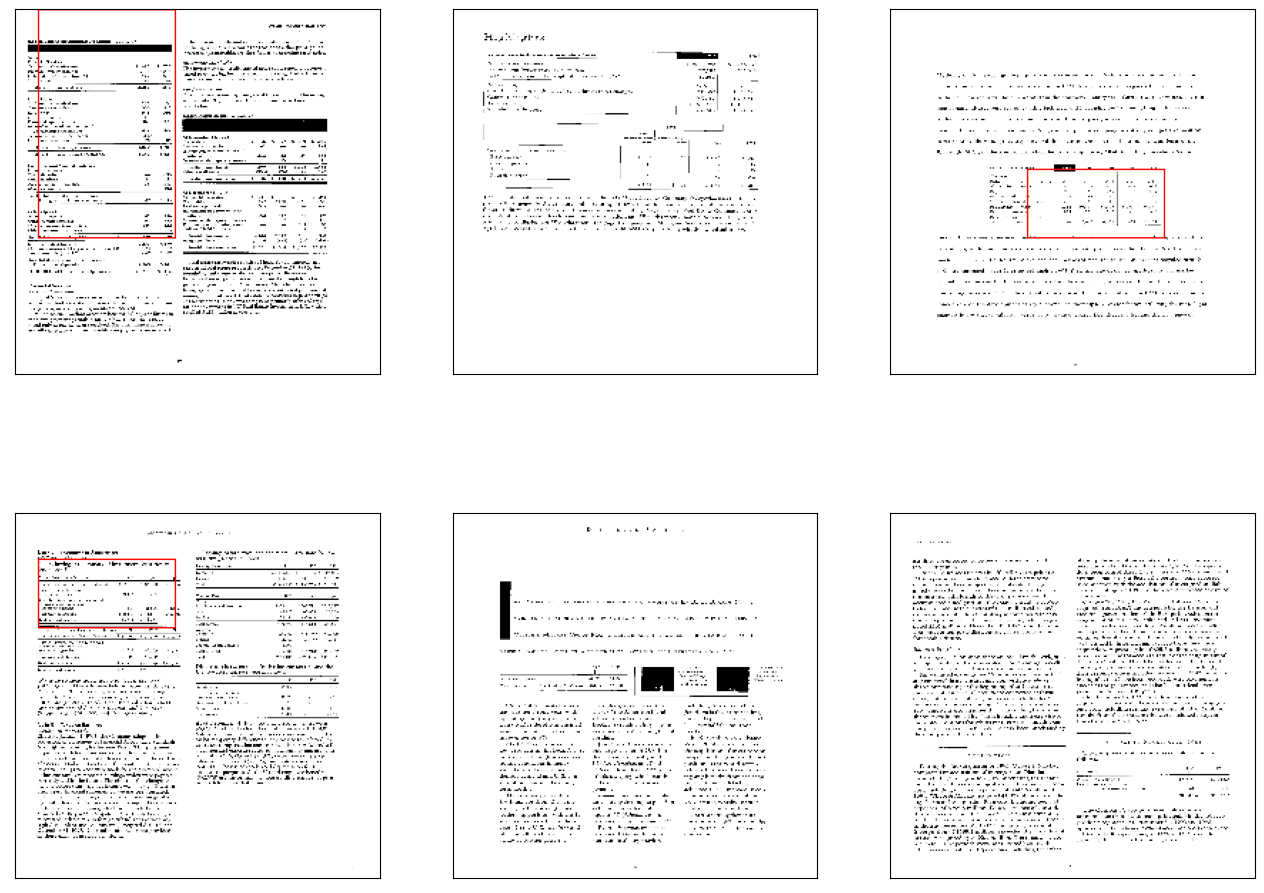

In [66]:
inference(data_gen_test, np.copy(test_images))